In [1]:
import datetime
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import requests
import json

pd.set_option('display.max_columns', None)

2022-10-30 19:04:48.921702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Several helper functions defined here to help clean and process data below

In [2]:
# helper functions
def add_month(date):
    return date + relativedelta(days=28)

def get_data_15min(dates, api_key, site_id, which_api):
    '''Arguments:
            List of dates each less than a month apart
            API key for solar API
            Site ID for solar API
            Either "power" or "energy" to select which API to use
        Returns:
            A pandas dataframe of all values requested from the time period spanned by the dates argument.
        
        Self-limits rate of requests to avoid API overload.'''
       
    df = pd.DataFrame()
    i = 0
    while i < len(dates) - 1:
        start_date = dates[i]
        end_date = dates[i+1]
        if which_api == 'power':
            uri = 'Omitted for privacy, but would contain all the arguments to this function if left'
            response = requests.get(uri)
            response.raise_for_status()
            response_json = json.loads(response.text)
            temp_df = pd.DataFrame(response_json['power']['values'])
            df = pd.concat([df, temp_df])
            time.sleep(0.5)
            i += 1
        elif which_api == 'energy':
            uri = f'Omitted for privacy, but would contain all the arguments to this function if left'
            response = requests.get(uri)
            response.raise_for_status()
            response_json = json.loads(response.text)
            temp_df = pd.DataFrame(response_json['energy']['values'])
            df = pd.concat([df, temp_df])
            time.sleep(0.5)
            i += 1
        else:
            print('Incorrect API selection')
    return df

def enum_months(start_date):
    '''Takes a start datetime and creates a list of dates in 28-day increments between the start date and today.
       Formats dates to the requirements of the API for solar panels.
       This is done because API will only do about a month per request.'''
    dates = [start_date.strftime('%Y-%m-%d') + '%20' + start_date.strftime('%H:%M:%S')]
    now = datetime.datetime.now()
    while start_date.date() < now.date() - relativedelta(days=28):
        start_date = add_month(start_date)
        dates.append(start_date.strftime('%Y-%m-%d') + '%20' + start_date.strftime('%H:%M:%S'))
    dates.append(now.strftime('%Y-%m-%d') + '%20' + now.strftime('%H:%M:%S'))
    return dates
    
    
def get_month(row):
    '''Turns month numbers into month names. To be applied to a pandas dataframe.'''
    if row['Month'] == 1:
        return 'January'
    elif row['Month'] == 2:
        return 'February'
    elif row['Month'] == 3:
        return 'March'
    elif row['Month'] == 4:
        return 'April'
    elif row['Month'] == 5:
        return 'May'
    elif row['Month'] == 6:
        return 'June'
    elif row['Month'] == 7:
        return 'July'
    elif row['Month'] == 8:
        return 'August'
    elif row['Month'] == 9:
        return 'September'
    elif row['Month'] == 10:
        return 'October'
    elif row['Month'] == 11:
        return 'November'
    elif row['Month'] == 12:
        return 'December'
    else:
        return None
    
    
def make_full_date(row):
    '''Makes a proper datetime from columns of a dataframe that specify
    year, month, day, hour minute.'''
    year = row.Year
    month = row.Month
    day = row.Day
    hour = row.Hour
    minute = row.Minute
    return datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), 0)

def get_cloud_type(row):
    '''Based on documentation from sun data, changes numeric cloud values into text.
       This lets us make more sense of one-hot encoding later.'''
    if row['Cloud Type'] == 0:
        return 'Clear'
    elif row['Cloud Type'] == 1:
        return 'Probably Clear'
    elif row['Cloud Type'] == 2:
        return 'Fog'
    elif row['Cloud Type'] == 3:
        return 'Water'
    elif row['Cloud Type'] == 4:
        return 'Super-Cooled Water'
    elif row['Cloud Type'] == 5:
        return 'Mixed'
    elif row['Cloud Type'] == 6:
        return 'Opaque Ice'
    elif row['Cloud Type'] == 7:
        return 'Cirrus'
    elif row['Cloud Type'] == 8:
        return 'Overlapping'
    elif row['Cloud Type'] == 9:
        return 'Overshooting'
    elif row['Cloud Type'] == 10:
        return 'Unknown'
    elif row['Cloud Type'] == 11:
        return 'Dust'
    elif row['Cloud Type'] == 12:
        return 'Smoke'
    elif row['Cloud Type'] == -15:
        return None
    else: 
        return None

___

# Data gathering, cleaning, feature engineering and normalization

### Data is fetched from the API for the solar panel stats, as well as the NSRDB website. 
In this case, I've omitted the cell where I make the API call to avoid sharing my API keys with the world. The data retrieved from the API was saved into the CSV that is imported a couple of cells down. 

### Load data from https://nsrdb.nrel.gov/data-viewer/download/intro

This is solar radiation data for specific 2km grid squares in the U.S. The grid square containing the house with the solar panels on it is used in this case. Data is in 30-minute intervals, which will be lined up with the solar data. To accomplish this I perform a left join with the NSRDB data as the primary dataframe, effectively dropping all the non-aligned times from the solar panel data. Future iterations might attempt to interpolate values into 15-minute intervals in the NSRDB data so that no solar panel data is removed. 

All location identifying data has been scrubbed from the CSV in this case. Please note if downloading NSRDB data yourself that the CSV will include information that could expose your 2km grid square. 

In [3]:
# first two lines of CSV are general info/keys so skip those
# and only load the actual data
sun_data = pd.read_csv('sun_stats.csv', header=2)

In [4]:
# create the full date column
sun_data['full_date'] = sun_data.apply(make_full_date, axis=1)

In the below cell I'm making the choice to fill power NaNs with zeros. In the vast majority of cases, the NaNs occur when the solar panels are producing no electricity and thus the inverter is powered down. Potential edge cases include power grid blackout, system down for maintenance, etc. but these will be very uncommon. Overall, it is important to be able to predict when the panels will not be generating power, and values of zero accurately describe such situations.

In [5]:
# join solar power data
solar_panel_power = pd.read_csv('power_15min_2022_demo.csv', parse_dates=['date'])
solar_panel_power = solar_panel_power.drop('Unnamed: 0', axis=1)
solar_panel_power.columns = ['date', 'power']
solar_panel_power = solar_panel_power.set_index(['date'])
sun_data = sun_data.set_index(['full_date'])

# joining with sun_data as primary deletes all non-aligned time rows
# from the solar panel data
all_data = sun_data.join(solar_panel_power)

all_data['power'] = all_data['power'].fillna(value=0)

In [6]:
# feature engineering

# turn month column into month names for later one-hot encoding
all_data['month_str'] = all_data.apply(get_month, axis=1)

# change cloud type names to strings
all_data['cloud_type'] = all_data.apply(get_cloud_type, axis=1)

# one-hot encode the months, hours of the day and cloud types
all_data = pd.concat([all_data, pd.get_dummies(all_data['month_str'], prefix='month')], axis=1)
all_data = pd.concat([all_data, pd.get_dummies(all_data['Hour'], prefix='hour')], axis=1)
all_data = pd.concat([all_data, pd.get_dummies(all_data['cloud_type'], prefix='cloud_type')], axis=1)

In [7]:
# randomize the data and do a train/test split
np.random.seed(3810)
all_data = all_data.reset_index()
all_data = all_data.reindex(np.random.permutation(all_data.shape[0]))
# calculate the index at which to split the data (80/20 train/test)
train_test_split = int(all_data.shape[0]*0.8)

# split the data
sun_train = all_data[:train_test_split]
sun_test = all_data[train_test_split:]

print(f'Training data shape: {sun_train.shape}\n\nTest data shape: {sun_test.shape}')

Training data shape: (14016, 96)

Test data shape: (3504, 96)


In [8]:
sun_train.columns

Index(['full_date', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'DHI',
       'Temperature', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Cloud Type', 'Dew Point', 'DNI', 'Fill Flag', 'GHI', 'Ozone',
       'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure',
       'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31',
       'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39',
       'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43',
       'Unnamed: 44', 'Unnamed: 45', 'power', 'month_str', 'cloud_type',
       'month_April', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'hour_0',
  

### Since I'm going to start with linear regression...

I'll have a look at a correlation heatmap of some of the training data to see which variables I might want to include. This is definitely not a deep enough investigation into input features -- I did some reading outside of this notebook and looked at several other plots. This is also not a model that will be used in production, so I am not doing as thorough of an exploratory analysis as I normally would.

As explained below, I intend to drop several semi-redundant variables to avoid multicollinearity in the linear regression model. I removed those variables in the heatmap as well to reduce clutter.

<AxesSubplot: >

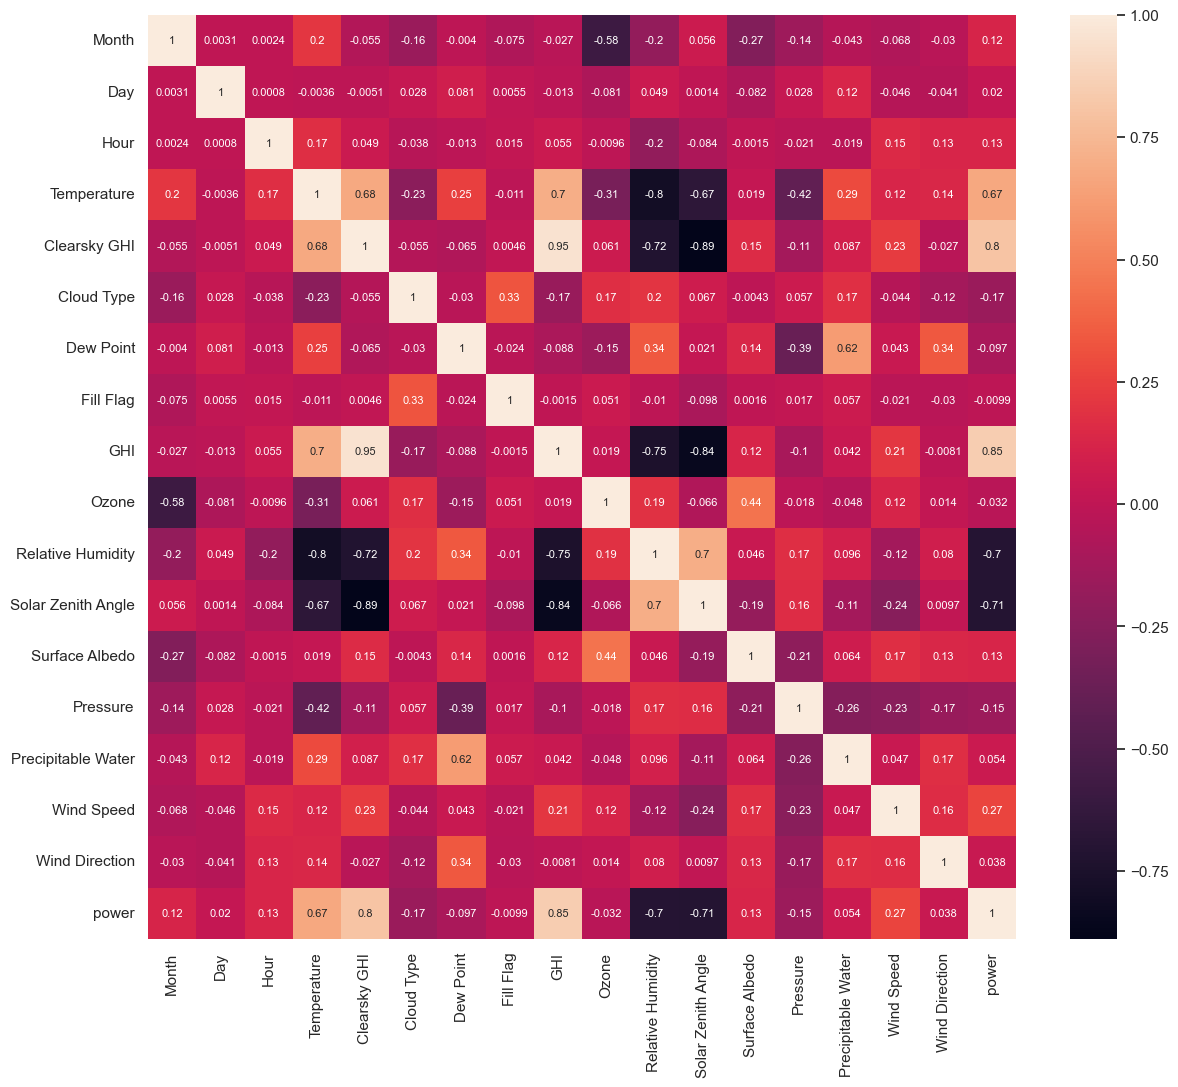

In [9]:
heatmap_data = sun_train[['Month', 'Day', 'Hour', 
                         'Temperature', 'Clearsky GHI',
                         'Cloud Type', 'Dew Point', 'Fill Flag',
                         'GHI', 'Ozone', 'Relative Humidity', 
                         'Solar Zenith Angle', 'Surface Albedo', 
                         'Pressure', 'Precipitable Water', 
                         'Wind Speed', 'Wind Direction', 'power']]
sns.set(rc={"figure.figsize":(14, 12)})
sns.heatmap(heatmap_data.corr(), annot=True, annot_kws={'fontsize':8})

### Select relevant features to this analysis

Some of the NSRDB data is redundant, so I select the most relevant features. For example, DHI, DNI and GHI measure very similar things, with GHI being probably the most descriptive of actual solar energy reaching the surface (it takes into account angle and diffusion, etc.) It would be poor statistical practice to include things that are highly correlated in the model, particularly a linear regression model as below, so I drop those values. Other redundant values are clearsky versions of GHI, DNI and DHI (I keep just cloud-corrected GHI). Based on earlier data exploration I have also decided to drop dew point, pressure, wind variables, and relative humidity, as they appeared to have very little correlation with the amount of solar energy produced. I keep cloud, time of day, temperature, and sun information. Future areas for exploration would be to conduct deeper assessment of some of the dropped variables, and consider other sources for data that might improve model performance. 

In [10]:
# isolate features and labels
features = ['Temperature', 'GHI',
'Solar Zenith Angle', 'month_April', 'month_August', 'month_December',
'month_February', 'month_January', 'month_July', 'month_June', 'month_March', 'month_May', 'month_November',
'month_October', 'month_September', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
'cloud_type_Cirrus', 'cloud_type_Clear', 'cloud_type_Fog', 'cloud_type_Opaque Ice', 'cloud_type_Overlapping',
'cloud_type_Overshooting', 'cloud_type_Probably Clear', 'cloud_type_Smoke', 'cloud_type_Super-Cooled Water', 'cloud_type_Water']

sun_train_features = sun_train[features]
sun_test_features = sun_test[features]
sun_train_labels = sun_train['power']
sun_test_labels = sun_test['power']

In [11]:
print(f'train features shape: {sun_train_features.shape},\ntest features shape {sun_test_features.shape}')

train features shape: (14016, 49),
test features shape (3504, 49)


### Neural networks, which use gradient descent, can often benefit from having normalized input features. 

Here I conduct z-score normalization using the mean and standard deviation of each column from the _training_ dataset (best practice dictates that we do not look at any information from the test dataset until model testing time). I use the mean and std to normalize each column to have a mean of zero and standard deviation of 1, so that values are all on the same scale across columns. This is not applied to one-hot encoded columns. 

In [12]:
# normalize numeric features

numeric_features = ['Temperature', 'GHI', 'Solar Zenith Angle']
sun_train_features_norm = sun_train_features.copy(deep=True)
sun_test_features_norm = sun_test_features.copy(deep=True)
for column in numeric_features:
    col_mean = sun_train_features[column].mean()
    col_std = sun_train_features[column].std()
    sun_train_features_norm[column] = (sun_train_features[column] - col_mean)/col_std
    sun_test_features_norm[column] = (sun_test_features[column] - col_mean)/col_std

#### Check out the dataframe to make sure normalization worked

In [13]:
sun_train_features_norm.describe()

,Temperature,GHI,Solar Zenith Angle,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,cloud_type_Cirrus,cloud_type_Clear,cloud_type_Fog,cloud_type_Opaque Ice,cloud_type_Overlapping,cloud_type_Overshooting,cloud_type_Probably Clear,cloud_type_Smoke,cloud_type_Super-Cooled Water,cloud_type_Water
count,1.401600e+04,1.401600e+04,1.401600e+04,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000
mean,-5.475072e-17,1.216683e-17,1.191335e-17,0.082549,0.083333,0.085474,0.075485,0.084332,0.085616,0.082977,0.085117,0.083975,0.083975,0.084832,0.082334,0.040668,0.041952,0.041809,0.042237,0.043094,0.041453,0.041595,0.042309,0.042880,0.043165,0.040240,0.041738,0.041809,0.041952,0.040811,0.042166,0.041738,0.041952,0.040739,0.041667,0.040382,0.041524,0.042166,0.039954,0.107092,0.588756,0.011772,0.013485,0.033961,0.000928,0.115083,0.000143,0.062215,0.066567
std,1.000000e+00,1.000000e+00,1.000000e+00,0.275208,0.276395,0.279595,0.264182,0.277895,0.279807,0.275857,0.279066,0.277361,0.277361,0.278641,0.274883,0.197527,0.200487,0.200160,0.201138,0.203075,0.199342,0.199670,0.201300,0.202593,0.203236,0.196528,0.199997,0.200160,0.200487,0.197858,0.200975,0.199997,0.200487,0.197692,0.199833,0.196861,0.199506,0.200975,0.195859,0.309241,0.492077,0.107863,0.115342,0.181136,0.030442,0.319133,0.011945,0.241554,0.249279
min,-2.160772e+00,-7.241222e-01,-2.020842e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.457842e-01,-7.241222e-01,-7.863039e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.763379e-01,-7.241222e-01,-8.977094e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.829238e-01,6.456338e-01,7.937054e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.223929e+00,2.

---

# Model creation and testing

### The first model will be linear regression

This will give me something to compare further iterations to. I also set a baseline guess for the linear regression, which is simply the average power value across the data, so that I can assess how much better the linear regression model performs than the "unlearned" baseline. 

In [14]:
# generate baselines for train and test
# the baseline will just be the average solar power generation

baseline_train = np.repeat(np.mean(sun_train_labels), sun_train_labels.shape[0])
baseline_test = np.repeat(np.mean(sun_train_labels), sun_test_labels.shape[0])

# have a look at the RMSE for both of these

def rmse(predictions, labels):
    '''
    Arguments:
        predictions: a vector of predicted values
        labels: a vector of actual values
    Returns: the root mean squared error between the vectors
    
    Vectors must be of equal length
    '''
    rmse = np.sqrt(np.sum((predictions - labels)**2)/labels.shape[0])
    return rmse


print(f'Training baseline RMSE: {rmse(baseline_train, sun_train_labels)}\n\nTesting baseline RMSE: {rmse(baseline_test, sun_test_labels)}') 

Training baseline RMSE: 1622.9032409498056

Testing baseline RMSE: 1635.1072794699649


In [15]:
# a function to plot training and validation loss
# from keras documentation at https://www.tensorflow.org/tutorials/keras/regression
# a copy of the license for this is included at the bottom of the notebook
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

In [16]:
def linear_regression_model(learning_rate):
    '''
    Arguments:
        learning_rate: the learning rate that is passed to the optimizer
    Returns:
        A tensorflow/keras compiled model to perform linear regression.
        
    The loss function is mean squared error for this model.
    '''
    
    tf.keras.backend.clear_session()
    # set seed for reproducible results
    tf.random.set_seed(3462)
    
    # create a sequential model with just one dense layer
    # this will do linear regression
    linear_model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            units=1,
            use_bias=True
        )
    ])
    
    # use a stochastic gradient descent optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    
    # compile the model with MSE as the loss function
    linear_model.compile(
        loss='mse',
        optimizer=optimizer
    )
    
    return linear_model

#### Train the linear regression model, plot the loss, and see how it does on the test data (by looking at root mean squared error)

2022-10-30 19:04:54.215447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ml/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Test RMSE: 734.2060763164521


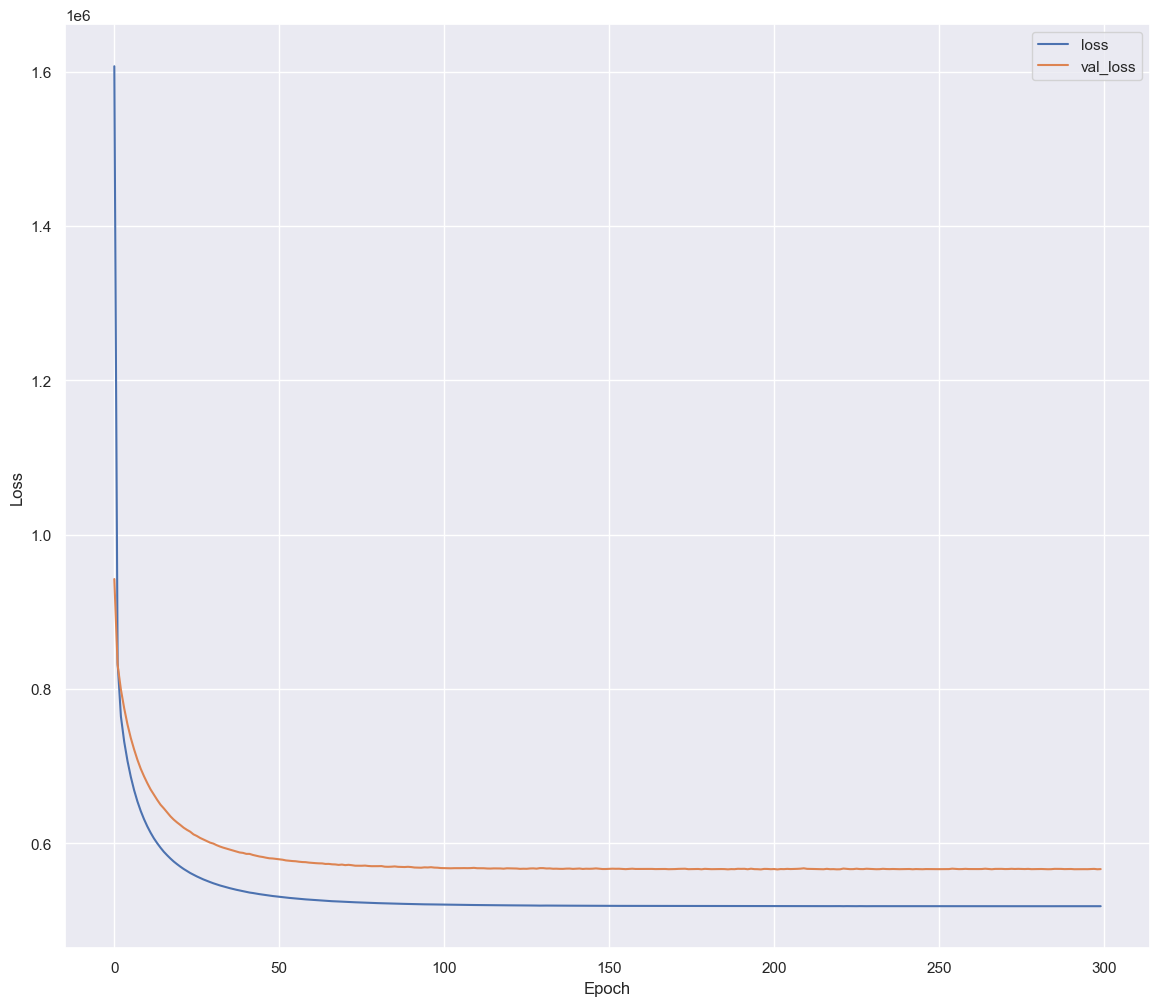

In [17]:
# build the model
linreg_model = linear_regression_model(0.001)

# fit the model to the data
history = linreg_model.fit(
    x=sun_train_features_norm,
    y=sun_train_labels,
    validation_split = 0.1,
    epochs=300,
    batch_size=32,
    verbose=0)

# plot the loss for training and validation
plot_loss(history)

# evaluate the model on the test data
test_data_mse = linreg_model.evaluate(
    sun_test_features_norm,
    sun_test_labels,
    verbose=0)

print('Test RMSE:', str(np.sqrt(test_data_mse)))


#### Let's also check out a summary of the linear regression model

In [18]:
linreg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 50        
                                                                 
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


### Linear regression model seems to have worked okay, but other models are likely to do better. Recap so far:

|Model|Test Data RMSE|
|-|-|
|Baseline|1635.11|
|Linear Regression|734.21|

### This time around I'll make a model with a couple of hidden layers, AKA a deep neural network

Adding a couple of nonlinear layers is likely to improve prediction considerably. Let's find out how much.

In [19]:
def create_dnn_model(learning_rate, activation='relu'):
    '''
    Arguments:

        learning_rate: the learning rate that is passed to the optimizer
        activation: the activation function to use for the hidden deep layers
    Returns:
        A tensorflow/keras compiled neural network model for prediction.
        
    The loss function is mean squared error for this model.
    '''

    tf.keras.backend.clear_session()
    
    # set seed for reproducible results
    tf.random.set_seed(6356)
    
    # make sure the specified activation function is available
    if activation not in ['relu', 'sigmoid', 'softmax',
                          'softplus', 'softsign', 'tanh', 
                          'selu', 'elu', 'exponential']:
        raise f'Unsupported activation function {activation}'
        
    # create a model
    # here I add two hidden layers
    # I'll use a nonlinear activation function
    # the output layer is still just a dense layer with one unit, like above
    dnn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            32,
            activation=activation),
        tf.keras.layers.Dense(
            16,
            activation=activation),
        tf.keras.layers.Dense(
            units=1,
            use_bias=True
        )
    ])
    
    # use the Adam optimizer 
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    # compile the model with MSE loss
    dnn_model.compile(
        loss='mse',
        optimizer=optimizer
    )
    
    return dnn_model

#### Train the DNN model, plot the loss, and see how it does on the test data (by looking at root mean squared error)

/opt/anaconda3/envs/ml/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Test RMSE: 397.39369647743536


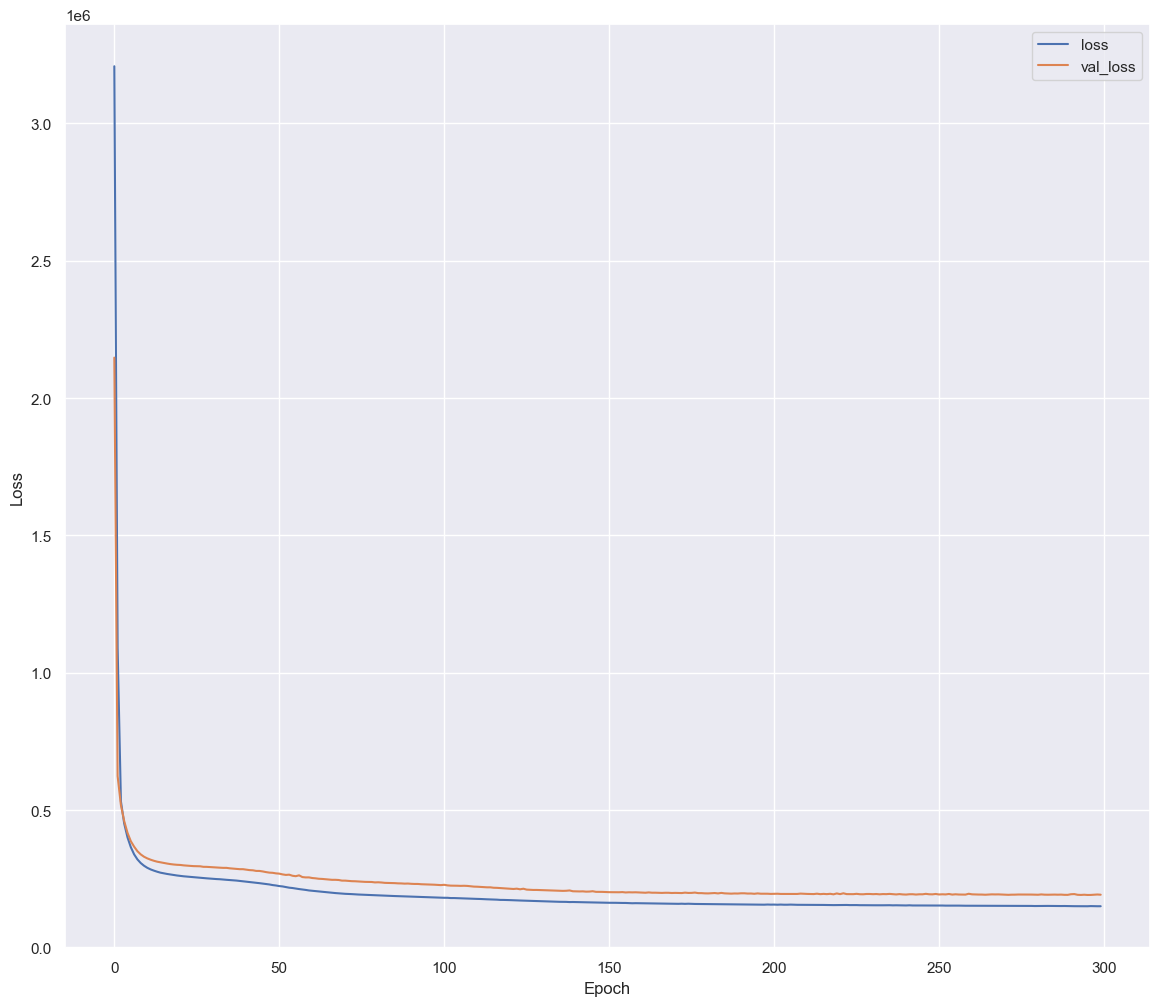

In [20]:
# build the model
dnn_model = create_dnn_model(learning_rate=0.001, activation='relu')


# fit the model
dnn_history = dnn_model.fit(
    x=sun_train_features_norm,
    y=sun_train_labels,
    validation_split = 0.1,
    epochs=300,
    batch_size=32,
    verbose=0)

# plot the loss for training and validation 
plot_loss(dnn_history)

# evaluate the model on the test data
dnn_test_data_mse = dnn_model.evaluate(
    sun_test_features_norm,
    sun_test_labels,
    verbose=0)

# print the RMSE for comparison to other models
print('Test RMSE:', str(np.sqrt(dnn_test_data_mse)))

#### Like above, look at a quick summary to get an idea of how much larger this model is

In [21]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1600      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________


### The DNN model is a _significant_ improvement over the linear regression model. Recap:

|Model|Test Data RMSE|
|-|-|
|Baseline|1635.11|
|Linear Regression|734.21|
|DNN (2 hidden layers)|397.39|


The power values are in watts on a solar array with just shy of 7kW total potential power output. Prediction to within ~400 watts in 30 minute increments seems satisfactory to me, but my guess is that this could get better with some more tinkering.


#### Future directions:

In a production situation, or if I _really_ wanted to improve the predictions on my solar panels, I would do some or all of the following:

   1. Dive deeper into research on how potential for solar energy generation is forecast in industry and seek out data to augment what's already here.
   
   
   2. Apply a correction factor to compensate for the fact that my roof (and therefore, the solar panels) is angled. GHI assumes a horizontal surface. 
   
   
   3. Create some automated testing infrastructure to loop through sets of different parameters for the model and choose the best one. What is shown here is the result of some manual parameter experimentation, but if I were really optimizing, I would want to at least try a number of different learning rates, batch sizes, and epochs. I would also want to dig into where the optimization/performance tradeoff is no longer worth it. You can observe above that the loss pretty much flattens out around 100 epochs, and the little bit extra that is obtained by going to 300 may not really be worth it. 
   
   
   4. Deep dive into the error and the model features -- does the model have a harder time predicting correctly during a certain part of the day? Under certain cloud cover conditions? When the temperature is really low? What sort of transformations or additional data might I be able to get to improve those predictions?
   
   
   5. Include some of the variables that were dropped for the linear regression in the DNN model and see what happens. A lot of the investigation of those variables was done using the correlation heatmap and some scatterplots that were not included here. Obviously correlation is only a measure of linear relation, and since our DNN includes non-linear layers, it might be useful to include some variables that weren't helpful to linear regression.
   
   
   5. It may also be worthwhile to see if predictions improve when NaN power values are dropped instead of changed to zero in the original solar panel data. 

## Thank you for following along!

__________

### License for the plot_loss function included above from Keras documentation, as well as any other snippets that may be present in this code from Keras documentation:

In [22]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
